# Benchmark Viewer

### System
- [overhead](#Overhead)

### Controller
- [variable SLA](#Variable-SLA)
- [variable input](#Variable-Input)
- [variable workload](#Variable-Workload)

### System
- [variable reqs/s](#System-Variable-reqs/s)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statistics as stat
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
cmap = plt.get_cmap('jet_r')
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

## System

In [2]:
def show_profiling_overhead(file, aggregate=False):
    with open(file, 'rb') as f:
        profiling_data = pickle.load(f)
    profiled_rt_data = profiling_data[0]
    # print(profiled_rt_data)
    
    for i, profiled_rt in enumerate(profiled_rt_data):
        
        if aggregate:
            profiled_rt_data_aggregate = []
            for j in range(0, len(profiled_rt), aggregate):
                mean = stat.mean(profiled_rt[j:j+aggregate])
                for _ in range(0, aggregate):
                    profiled_rt_data_aggregate.append(mean)
            profiled_rt = profiled_rt_data_aggregate
        
        x_val = np.arange(len(profiled_rt))
        plt.xlabel('Req')
        plt.ylabel('Response time [s]')
        # plt.title('Profiled Response time')
        plt.plot(x_val, profiled_rt, label="Data " + str(i+1))

        avg_rt = stat.mean(profiled_rt)
        min_rt = min(profiled_rt)
        max_rt = max(profiled_rt)
        dev_rt = stat.variance(profiled_rt)
        print("Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}".format(min_rt, max_rt, avg_rt, dev_rt))
    
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()


def show_benchmark_overhead(files, aggregate=False):
    for i, file in enumerate(files):
        with open(file, 'rb') as f:
            benchmark_data = pickle.load(f)

        sampling_time = 2
        benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
        benchmark_rt_process = list(filter(lambda rt: rt is not None, benchmark_data[1]))

        avg_rt = stat.mean(benchmark_rt)
        min_rt = min(benchmark_rt)
        max_rt = max(benchmark_rt)
        dev_rt = stat.variance(benchmark_rt)
        print("Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}".format(min_rt, max_rt, avg_rt, dev_rt))
        avg_rt = stat.mean(benchmark_rt_process)
        min_rt = min(benchmark_rt_process)
        max_rt = max(benchmark_rt_process)
        dev_rt = stat.variance(benchmark_rt)
        print("PROCESS: Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}\n".format(min_rt, max_rt, avg_rt, dev_rt))

        if aggregate:
            benchmark_rt_aggregate = []
            for j in range(0, len(benchmark_rt), aggregate):
                mean = stat.mean(benchmark_rt[j:j+aggregate])
                for _ in range(0, aggregate):
                    benchmark_rt_aggregate.append(mean)
            benchmark_rt = benchmark_rt_aggregate
        
        # plot
        x_val = np.arange(len(benchmark_rt))
        plt.xlabel('Time [s]')
        plt.ylabel('Response time [s]')
        # plt.title('Response Time')
        plt.plot(x_val*sampling_time, benchmark_rt, label="Data " + str(i+1))
        # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(x_val), label="avg RT")
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

### Overhead
- CPU

In [ ]:
base_folder = "overhead/"
print("--- PROFILING ---")
for model in ["googlenet", "resnet_NHWC", "alexnet", "vgg16", "skyline_extraction"]:
    print(model)
    show_profiling_overhead(base_folder + "profiling_" + model + ".out", aggregate=2)

print("--- BENCHMARK ---")
load_sizes = ["small", "medium", "large"]
print("resnet_NHWC")
show_benchmark_overhead([base_folder + "benchmark_resnet_NHWC_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print("googlenet")
show_benchmark_overhead([base_folder + "benchmark_googlenet_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print("skyline")
show_benchmark_overhead([base_folder + "benchmark_skyline_extraction_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print("vgg16")
show_benchmark_overhead([base_folder + "benchmark_vgg16_" + load_size + ".out" for load_size in load_sizes], aggregate=2)

## Controller

In [3]:
def show_values(file, sampling_time, title=False, verbose=False, aggregate=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)

    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    benchmark_rt_process = list(filter(lambda rt: rt is not None, benchmark_data[1]))
    benchmark_req = benchmark_data[2]
    benchmark_sent = benchmark_data[3]
    for i,_ in enumerate(benchmark_sent):
        for j,_ in enumerate(benchmark_sent[i]):
            benchmark_sent[i][j] = benchmark_sent[i][j] / sampling_time
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
            
            
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
        
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate

    if verbose:
        print("avgs rt: ", benchmark_rt)
        print("avg rt: ", stat.mean(benchmark_rt))
        print("req: ", benchmark_req)
        print("req sent: ", benchmark_sent)
        print("model_sla: ", benchmark_model_sla)
        # print("containers: ", benchmark_containers)
        print("containers_quota: ", benchmark_container_quota)
        
    # plot
    x_val = np.arange(len(benchmark_rt))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    # slas = set(benchmark_model_sla)
    plt.xlabel('Time [s]')
    plt.ylabel('Response time [s]')
    if title:
        plt.title('Response Time')
    
    plt.plot(x_val*sampling_time, benchmark_model_sla[:len(benchmark_rt)], ':', label="Model SLA", linewidth=3)
    plt.plot(x_val*sampling_time, benchmark_rt, label="Response Time", linewidth=3)
    # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(benchmark_rt), '--', label="Avg RT")
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    x_val = np.arange(len(benchmark_req))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    plt.xlabel('time [s]')
    plt.ylabel('# requests (completed + created)')
    if title:
        plt.title('# requests')
    plt.plot(x_val*sampling_time, benchmark_req, linewidth=3)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    plt.xlabel('Time [s]')
    plt.ylabel('Load [r/s]')
    if title:
        plt.title('Workload')
    lines = plt.plot(x_val*sampling_time, benchmark_sent, linewidth=3)
    labels = []
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("load " + str(l+1))
    plt.legend(iter(lines), labels, loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    plt.xlabel('Time [s]')
    plt.ylabel('SLA [s]')
    if title:
        plt.title('Model SLA')
    plt.plot(x_val*sampling_time, benchmark_model_sla[:len(x_val)], linewidth=3)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    for container in benchmark_container_quota:
        plt.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], label="Allocated Cores", linewidth=3) # label="container[:12]")
    plt.legend(loc=1)
    plt.xlabel('Time [s]')
    plt.ylabel('# cores')
    if title:
        plt.title('Allocated Cores')
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()
    
    # plot cores and sla
    x_val = np.arange(len(benchmark_model_sla))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.grid(True, linewidth=0.3, linestyle='-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('SLA [s]', color=color)
    lines = ax1.plot(x_val*sampling_time, benchmark_model_sla[:len(x_val)], ':', color=color, label="Model SLA", linewidth=3)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('# cores', color=color)
    for container in benchmark_container_quota:
        lines += ax2.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], label="Allocated Cores", linewidth=3) # label="container[:12]")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    if title:
        plt.title('Allocated Cores and Model SLA')
    labels = [l.get_label() for l in lines]
    plt.legend(iter(lines), labels, loc=1)
    plt.show()
    
    # plot cores and load
    x_val = np.arange(len(benchmark_sent))
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.grid(True, linewidth=0.3, linestyle='-')

    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Load [r/s]', color=color)
    
    labels = []
    lines = ax1.plot(x_val*sampling_time, benchmark_sent, '--', linewidth=3)
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("Load " + str(l+1))
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('# cores', color=color)
    for container in benchmark_container_quota:
        lines += ax2.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], color=color, linewidth=3) # label="container[:12]")
        labels.append("Allocated Cores")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    if title:
        plt.title('Workload and Model SLA')
    plt.legend(iter(lines), labels, loc=1)
    plt.show()

### Variable SLA

In [4]:
base_folder = "controller/sla/"

#### resnet_NHWC

with tfserving:latest


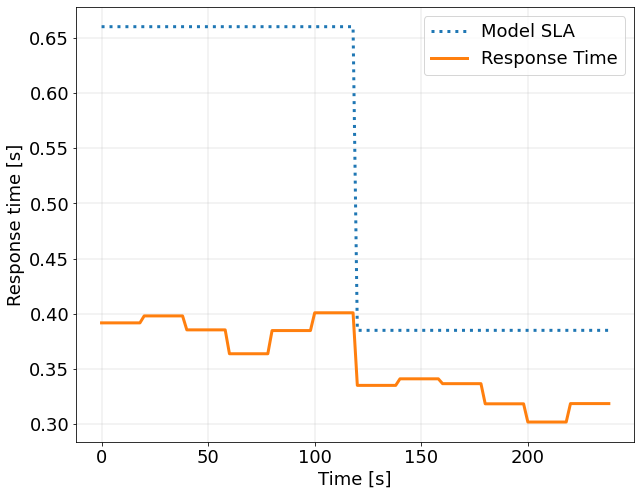

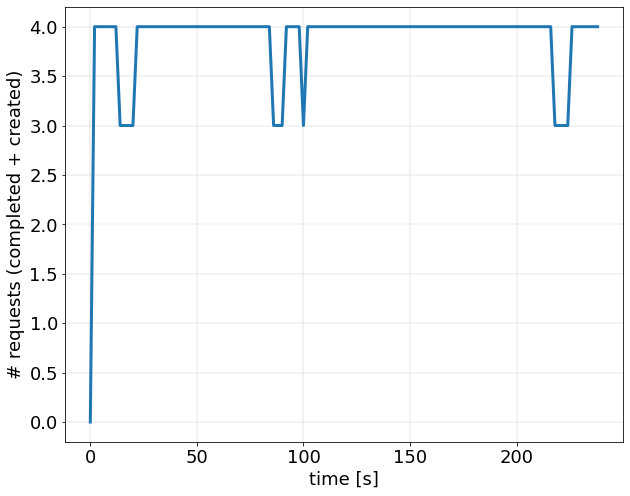

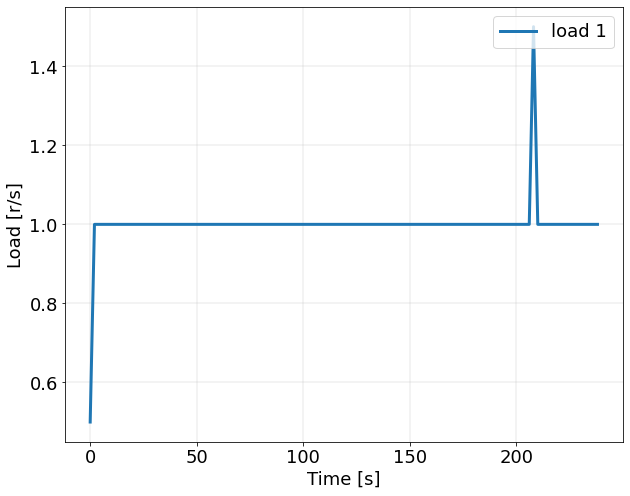

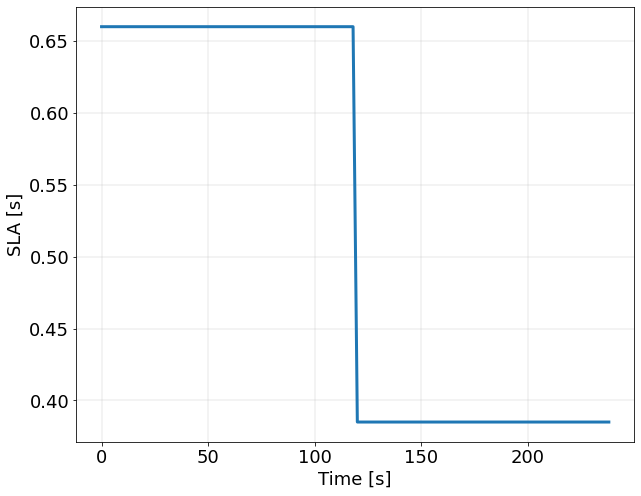

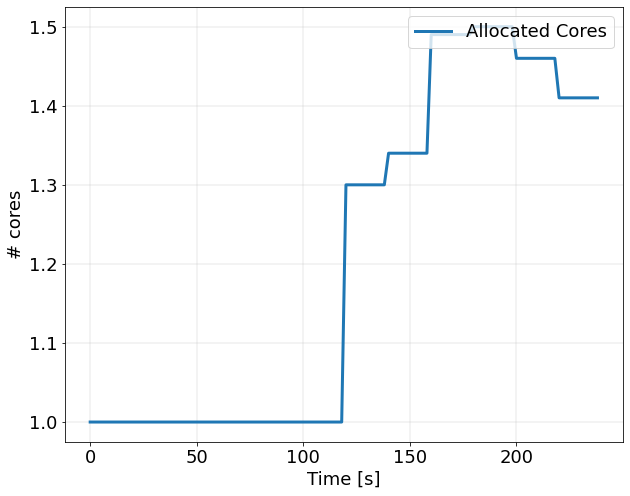

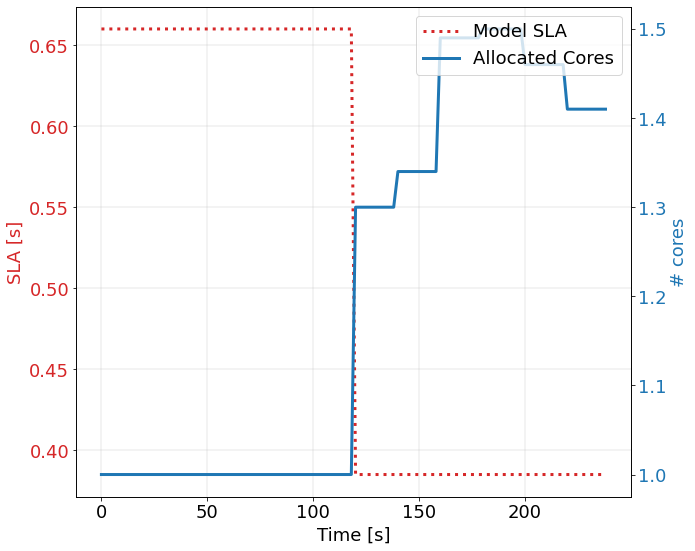

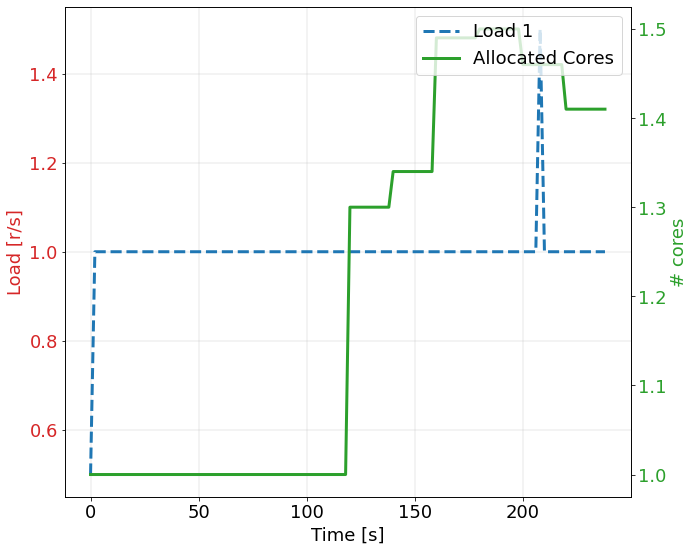

with tfserving:2.0.0


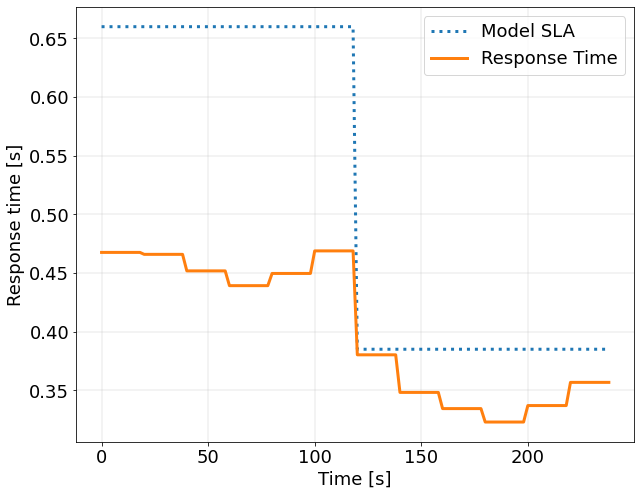

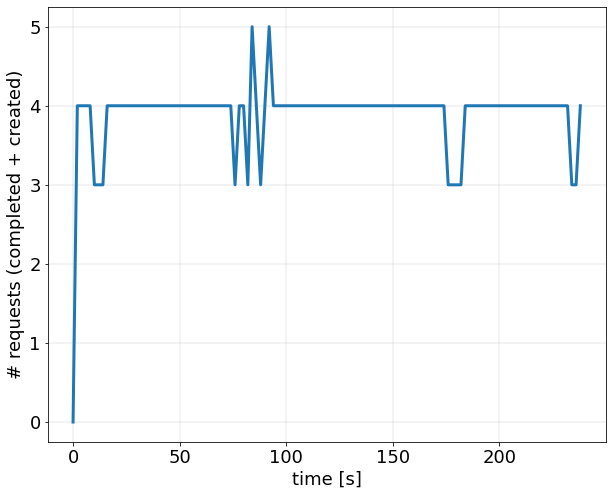

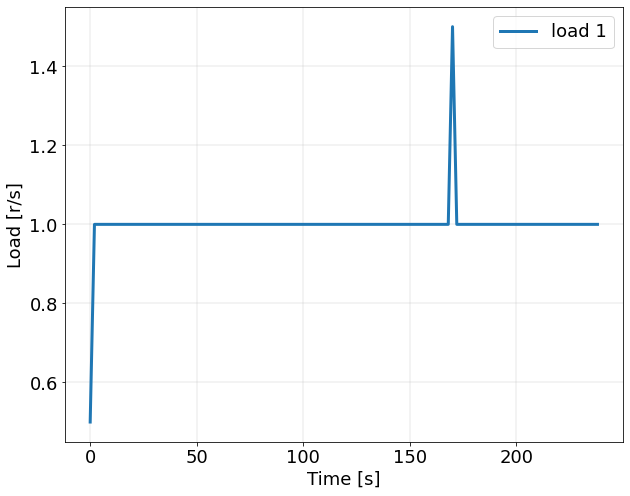

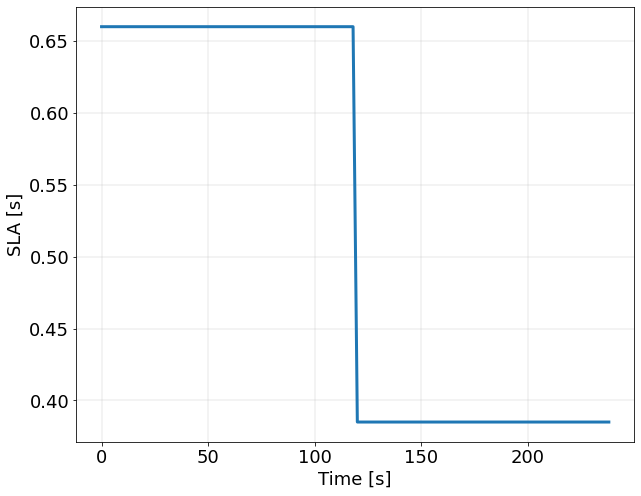

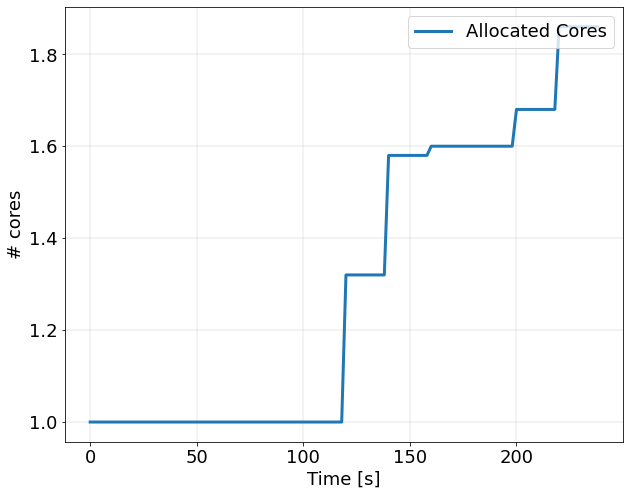

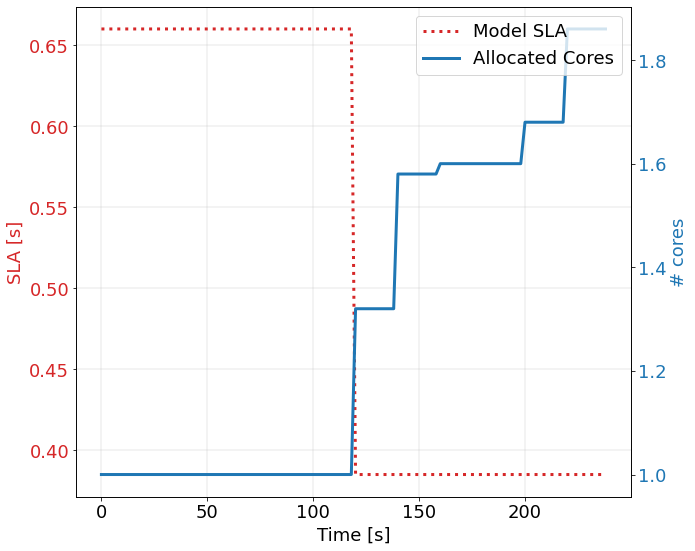

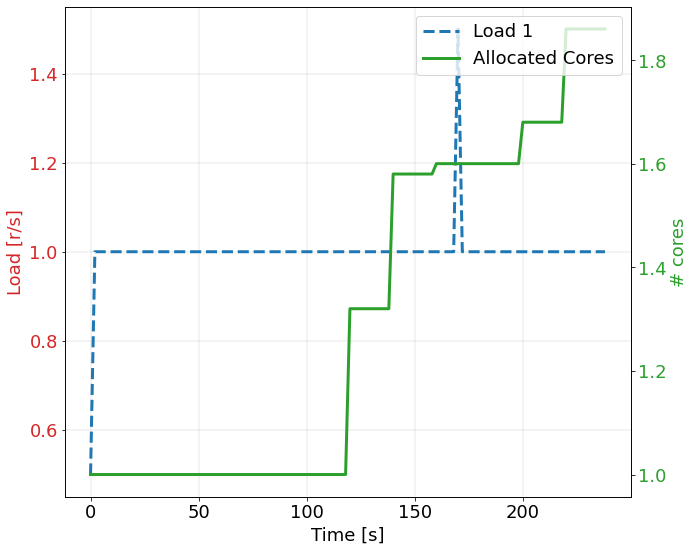

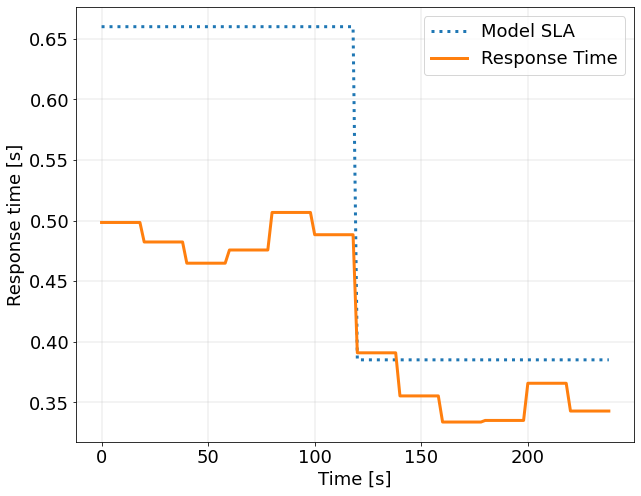

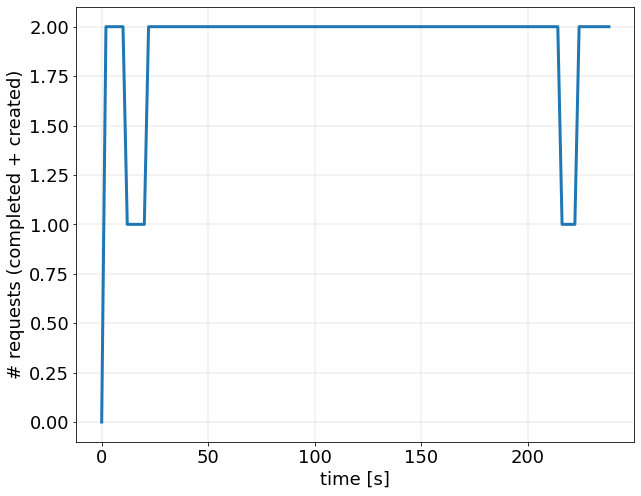

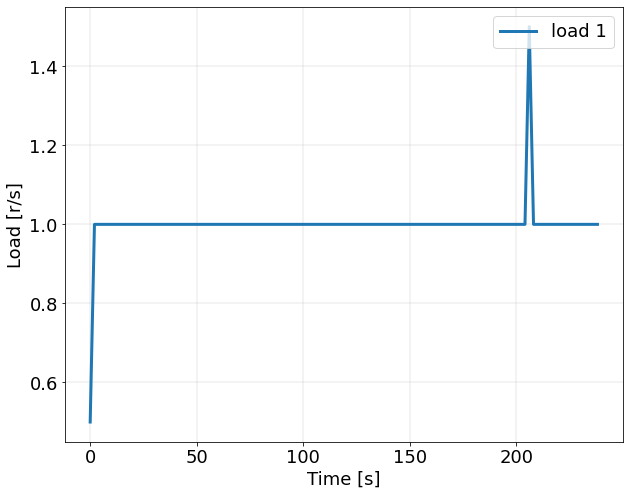

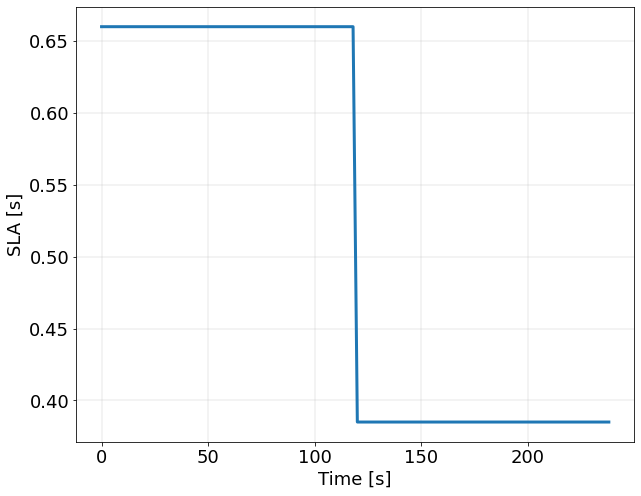

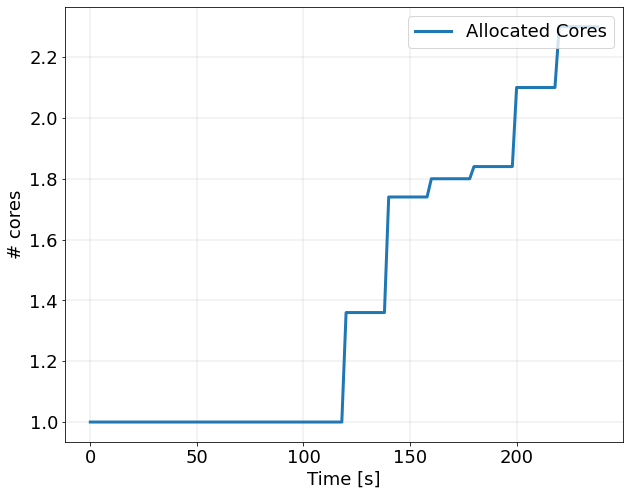

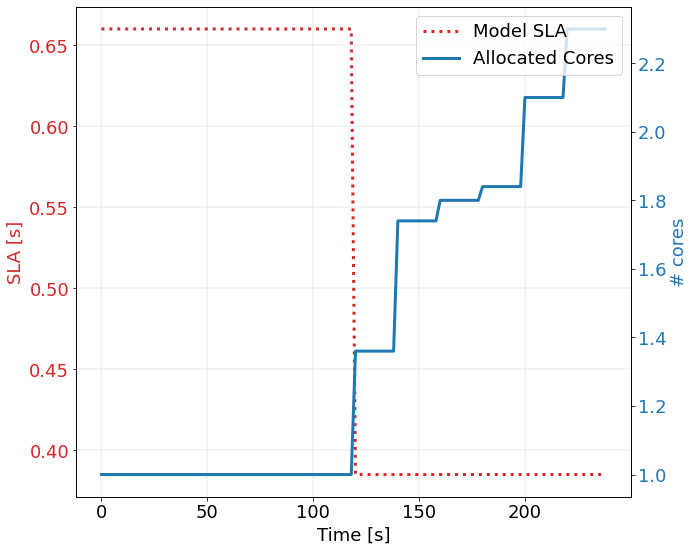

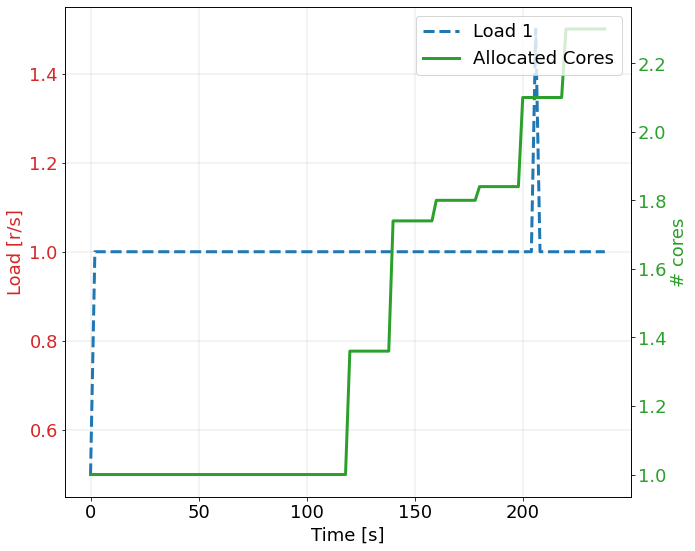

In [15]:
print("with tfserving:latest")
show_values(base_folder + "benchmark_resnet_NHWC.out", 2, aggregate=10)
print("with tfserving:2.0.0")
show_values(base_folder + "benchmark_resnet_NHWC_2.0.0.out", 2, aggregate=10)
show_values(base_folder + "benchmark_resnet_NHWC.out.old", 2, aggregate=10)

#### vgg16

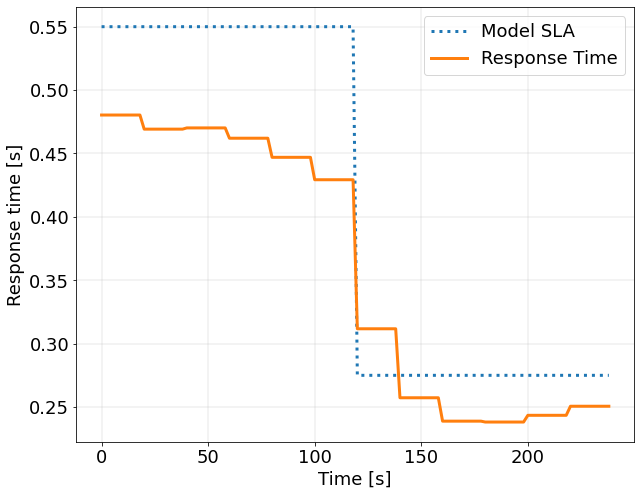

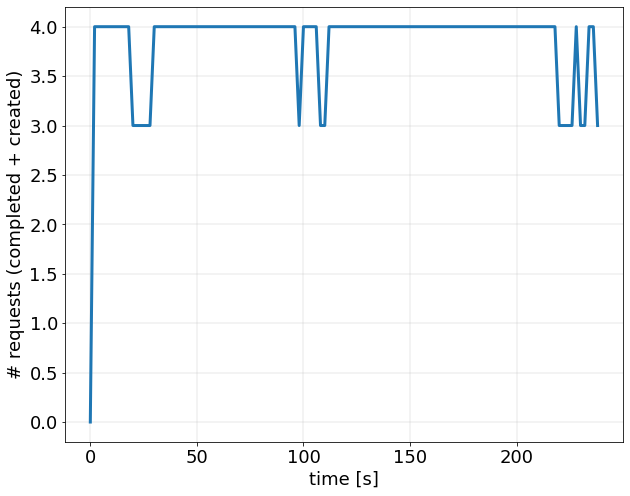

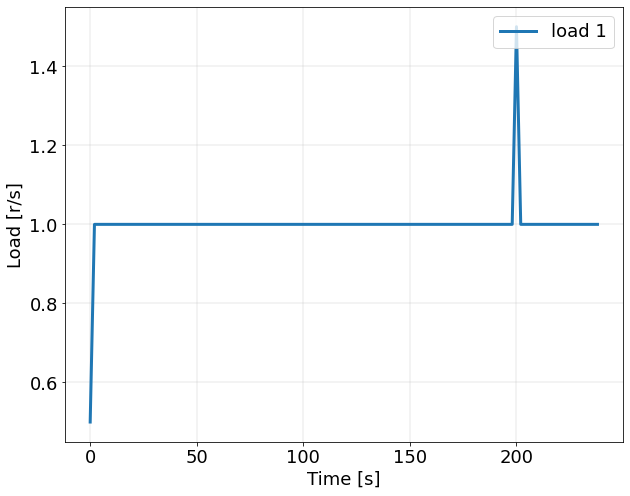

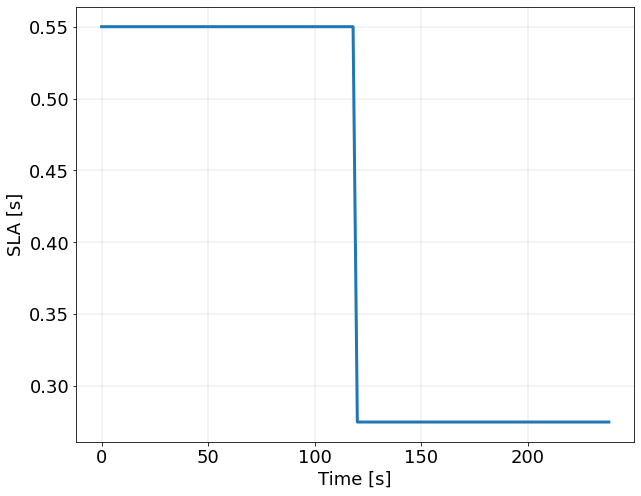

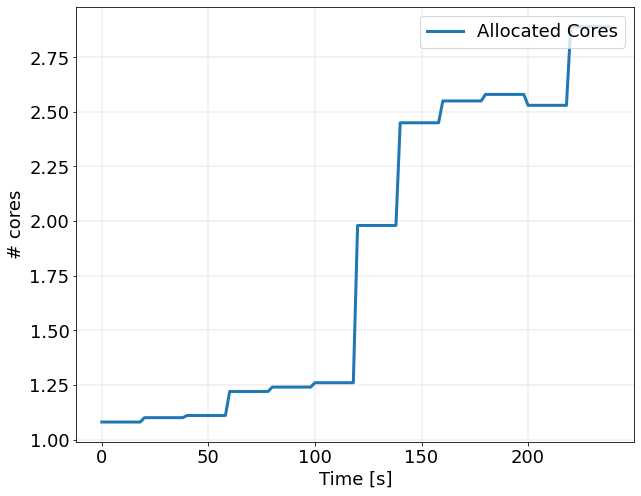

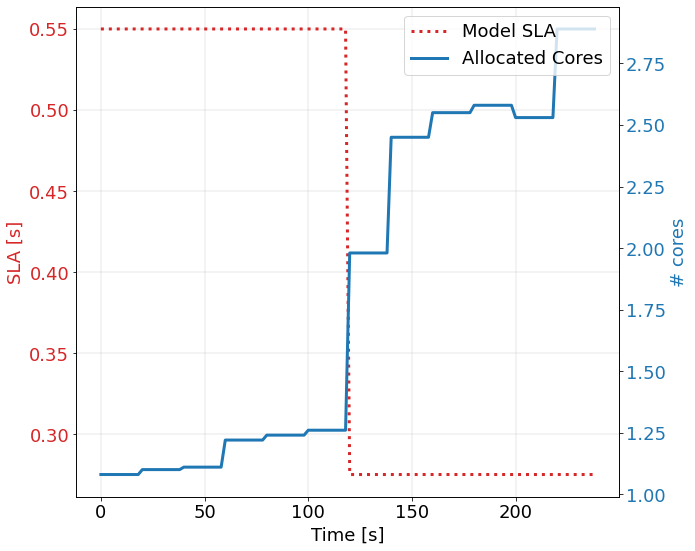

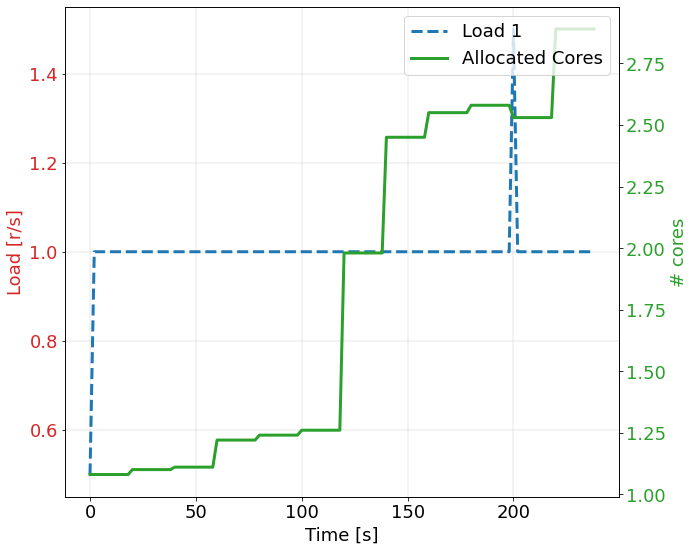

In [106]:
show_values(base_folder + "benchmark_vgg16.out", 2, aggregate=10)

#### googlenet

--------------- 22/04


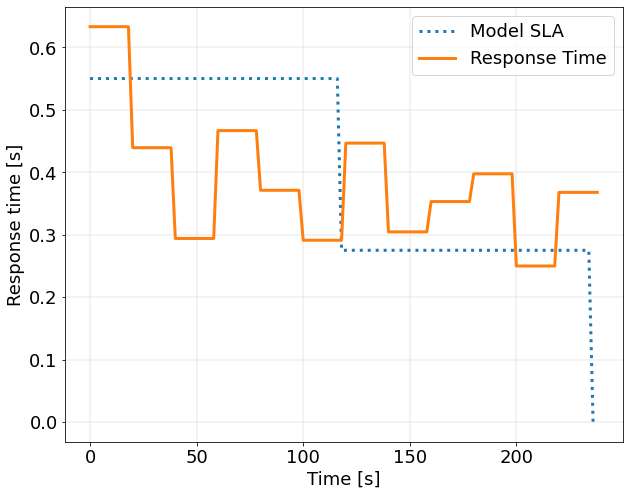

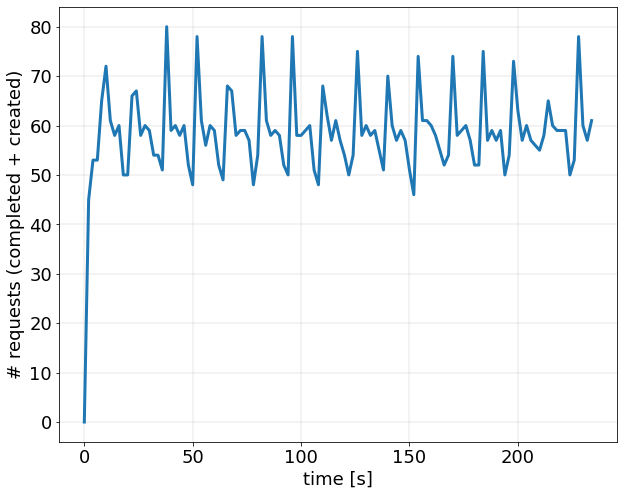

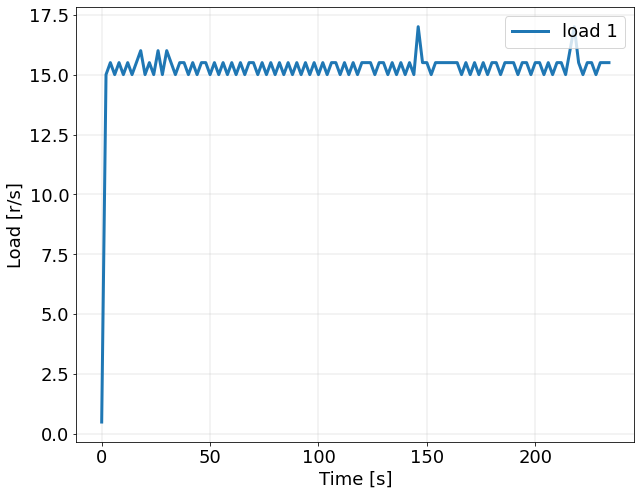

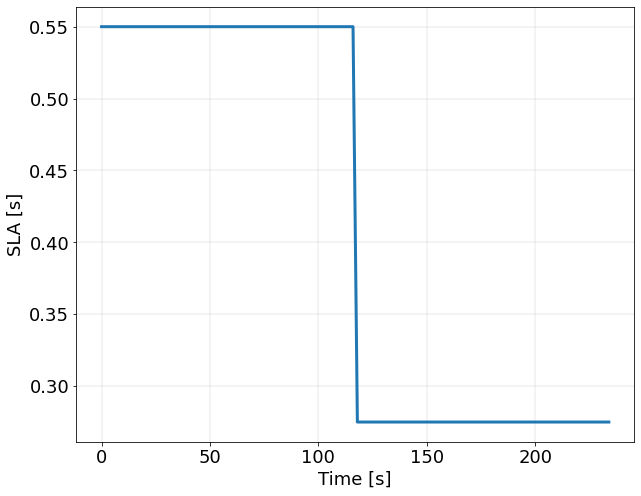

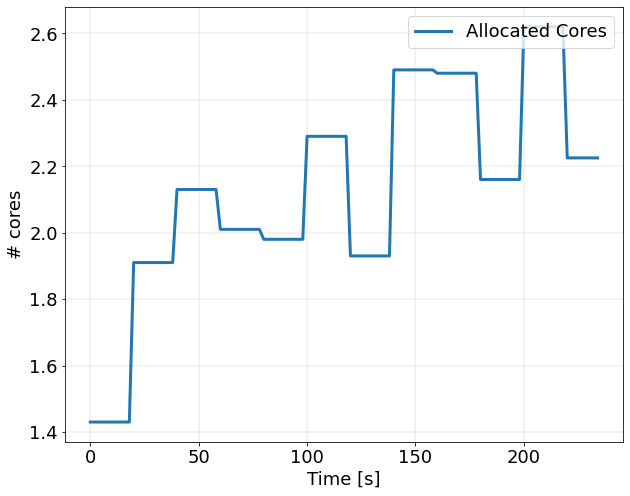

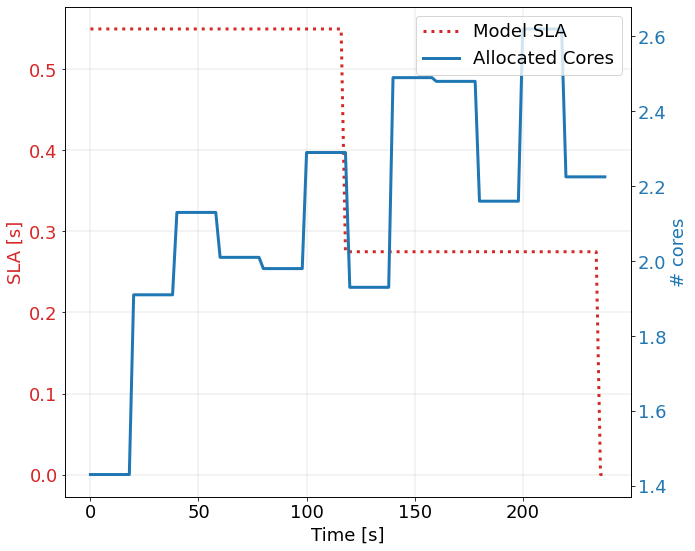

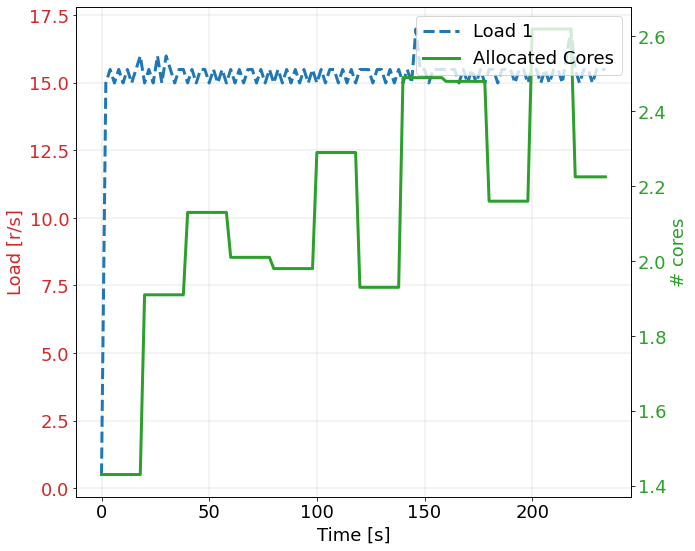

--------------- control period=1s


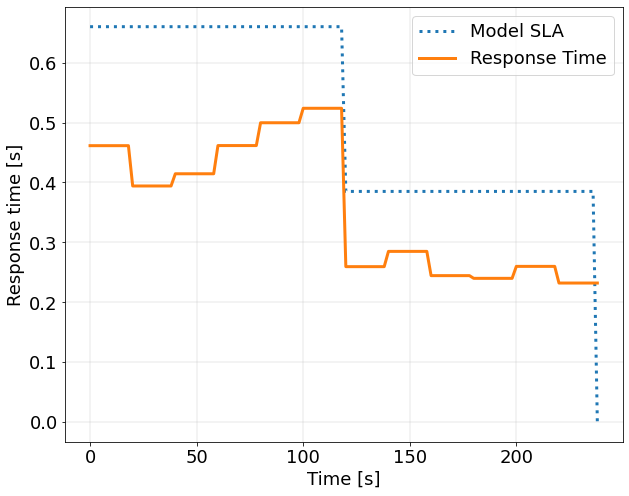

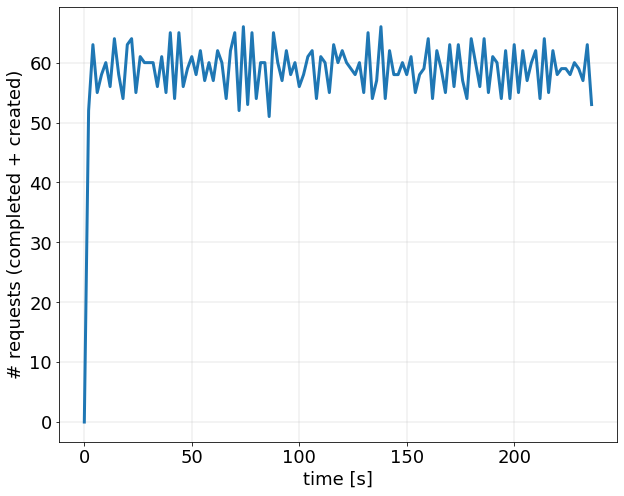

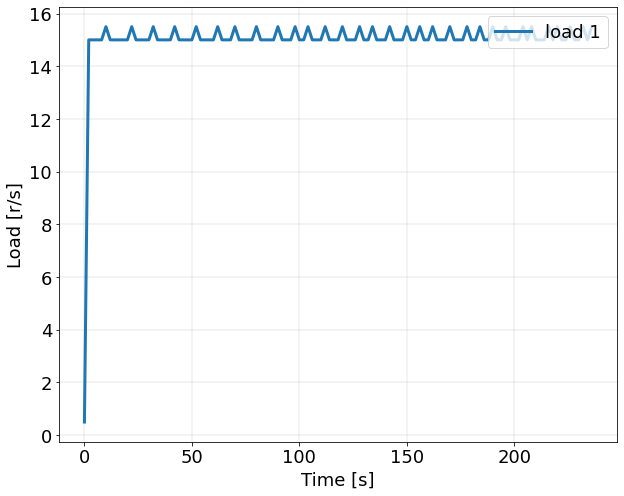

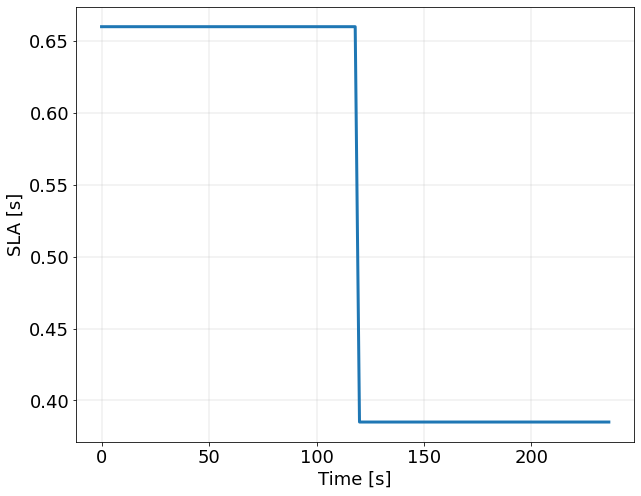

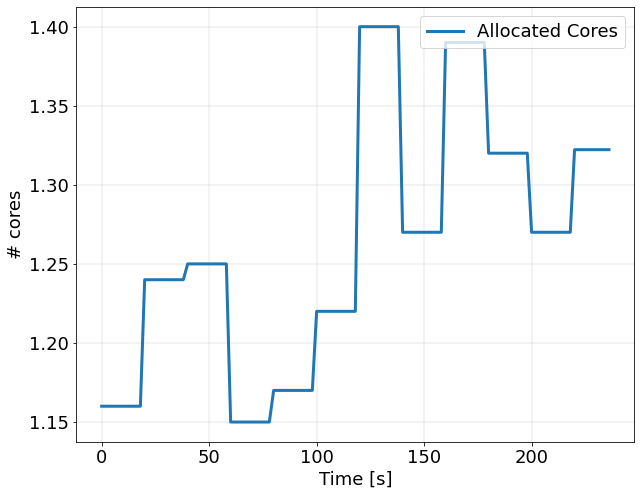

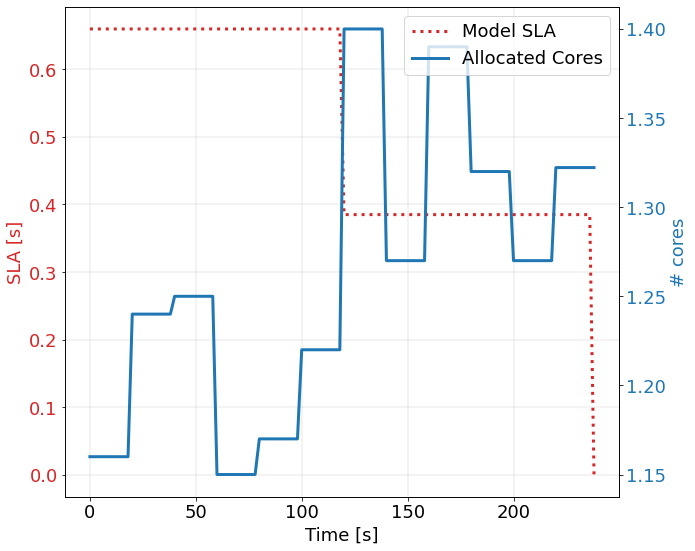

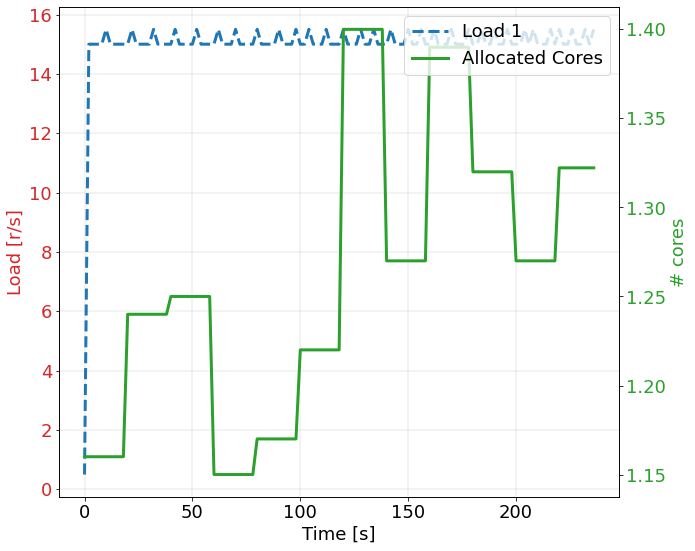

--------------- control period=1s, rounding 3rd decimal digit


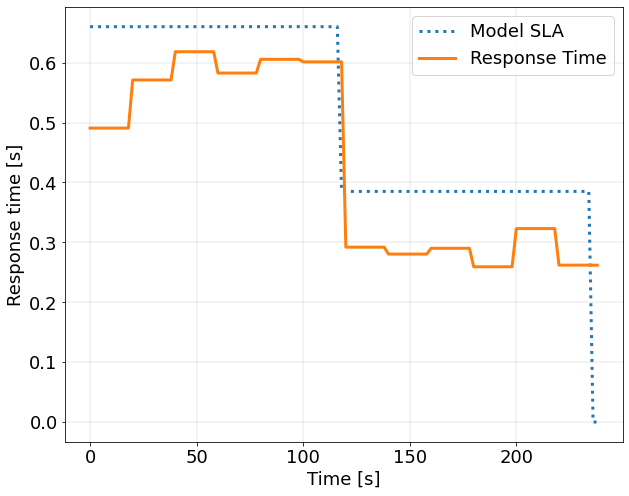

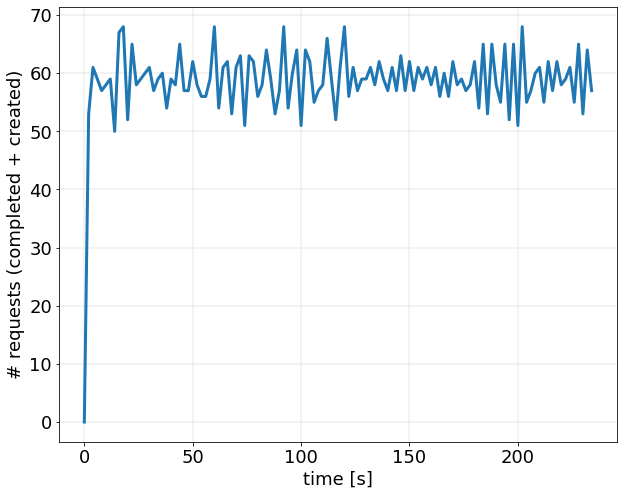

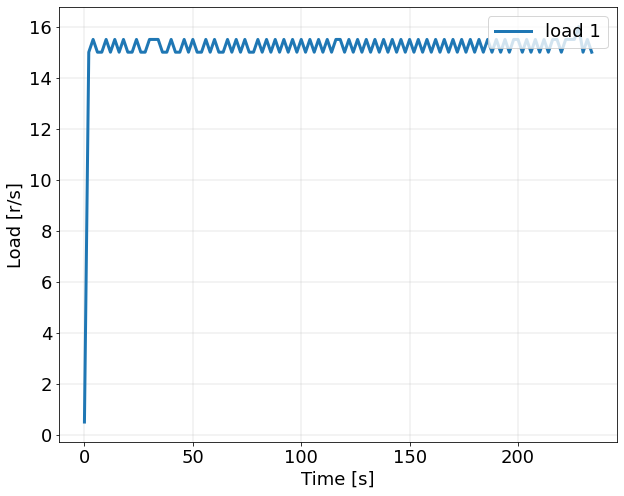

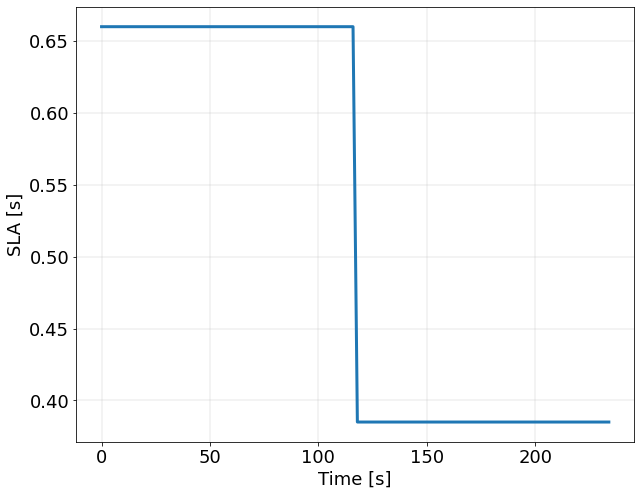

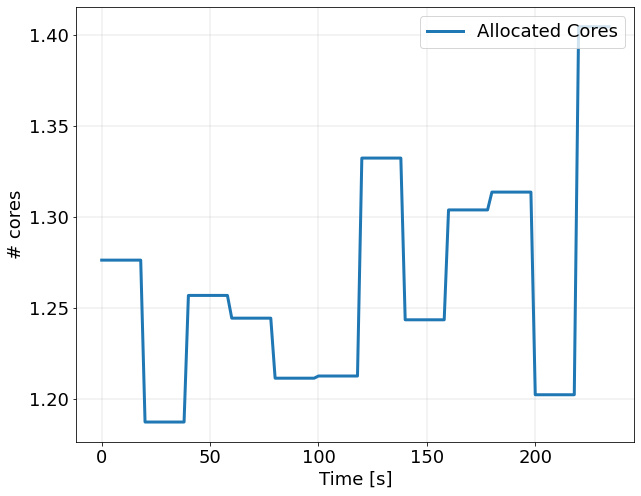

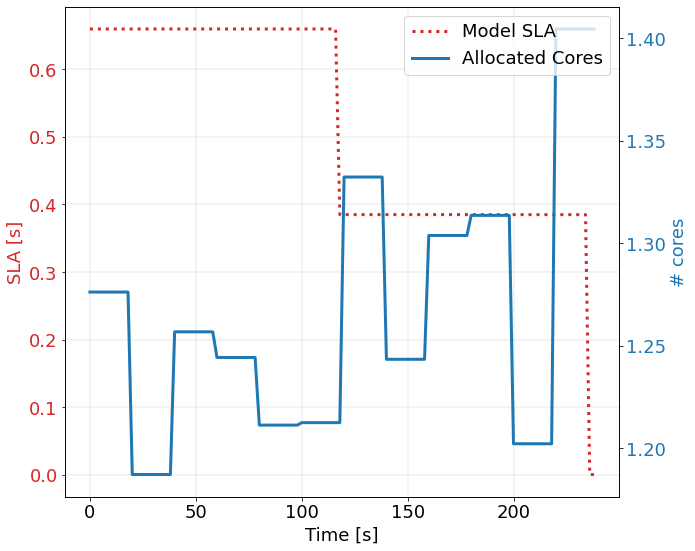

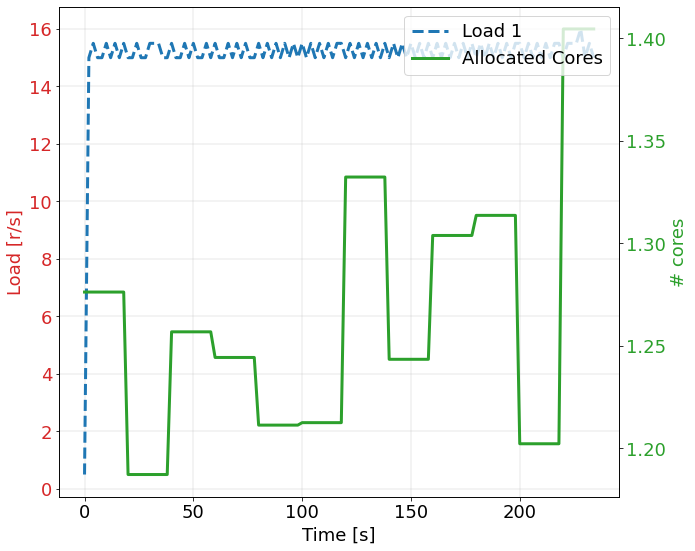

--------------- control period=1s, b_c=0.15, d_c=0.11 (-0.05 rispetto originale)


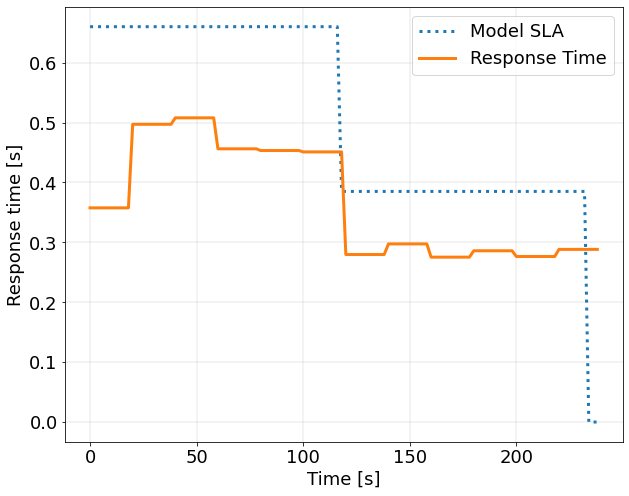

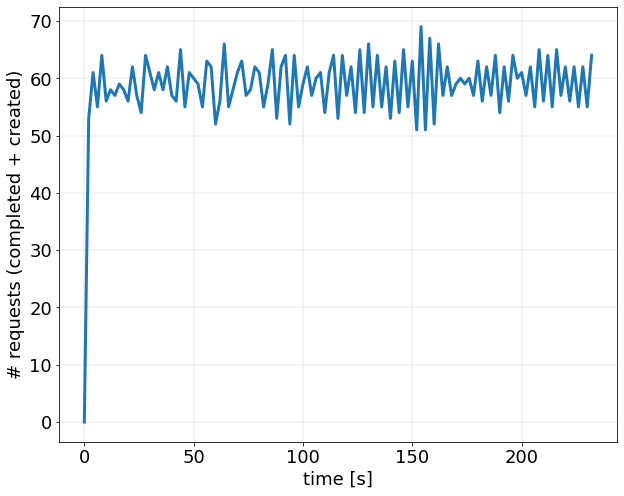

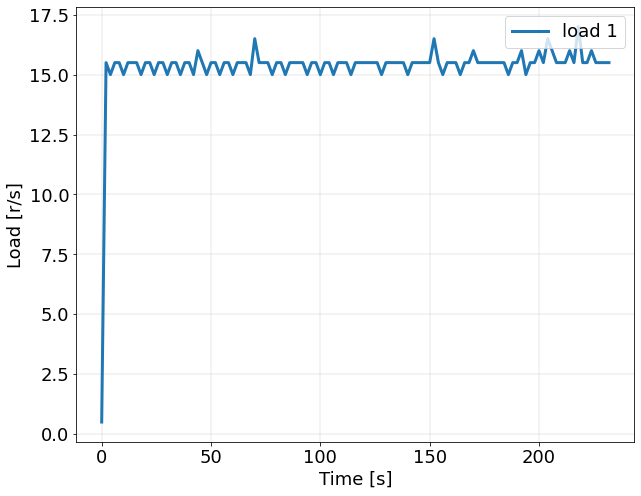

In [ ]:
print("--------------- 22/04")
show_values(base_folder + "benchmark_googlenet_2204.out", 2, aggregate=10)
print("--------------- control period=1s")
show_values(base_folder + "benchmark_googlenet_cp1s.out", 2, aggregate=10)
print("--------------- control period=1s, rounding 3rd decimal digit")
show_values(base_folder + "benchmark_googlenet_cp1s_round3.out", 2, aggregate=10)
print("--------------- control period=1s, b_c=0.15, d_c=0.11 (-0.05 rispetto originale)")
show_values(base_folder + "benchmark_googlenet_cp1s_-0.05.out", 2, aggregate=10)
print("--------------- control period=5s, b_c=0.15, d_c=0.11 (-0.05 rispetto originale)")
show_values(base_folder + "benchmark_googlenet_-0.05.out", 2, aggregate=10)
print("--------------- NEW control period=1s, tf=2.0.0, rounding=3, b_c=0.10, d_c=0.08 (metà rispetto originale)")
show_values(base_folder + "benchmark_googlenet_p2.out", 2, aggregate=1)
print("--------------- NEW control period=1s, tf=2.0.0, rounding=3, b_c=0.05, d_c=0.04 (¼ rispetto originale)")
show_values(base_folder + "benchmark_googlenet_p4.out", 2, aggregate=1)

#### skyline_extraction min_c=1

In [ ]:
show_values(base_folder + "benchmark_skyline_extraction.out", 2, aggregate=10)

### Variable Input / Load

In [ ]:
base_folder = "controller/input/"
show_values(base_folder + "benchmark_resnet_NHWC.out", 2, aggregate=10)

### Variable Workload / req/s

In [100]:
base_folder = "controller/reqs/"

#### resnet_NHWC

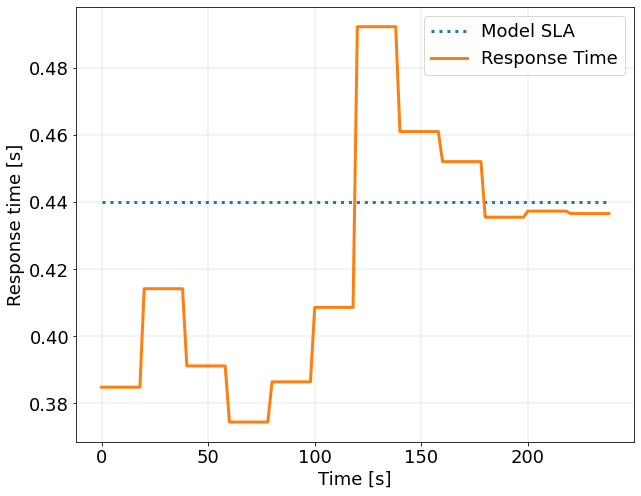

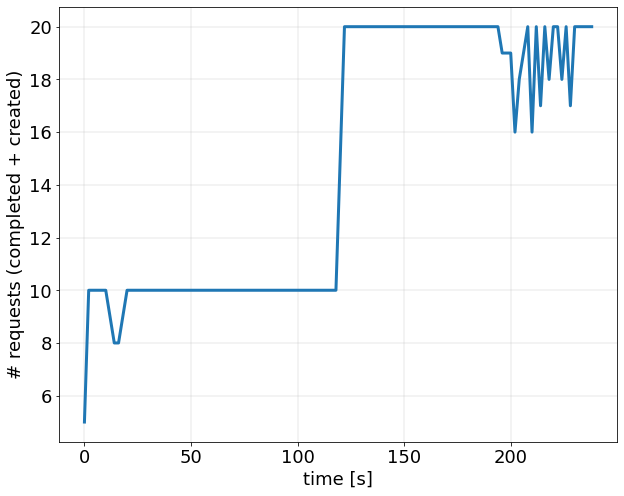

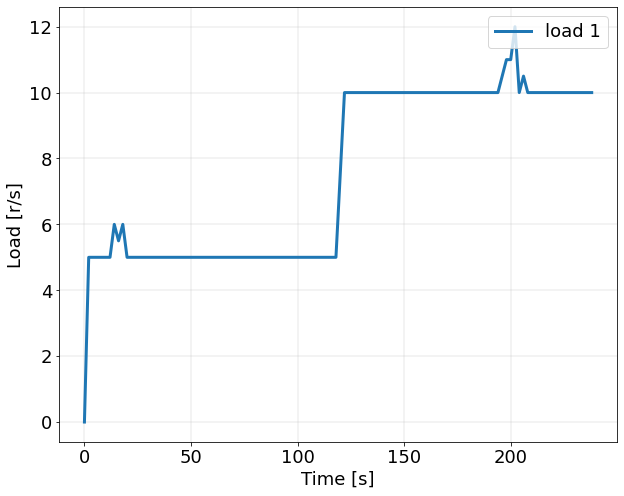

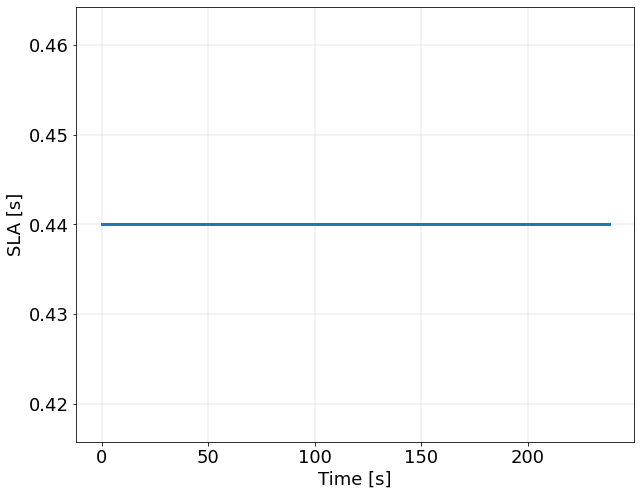

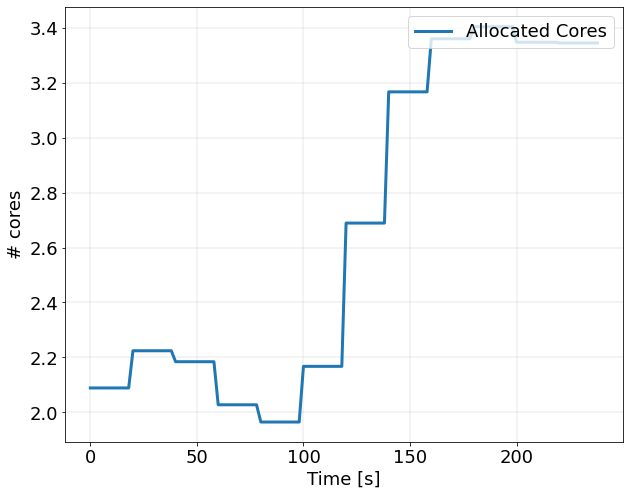

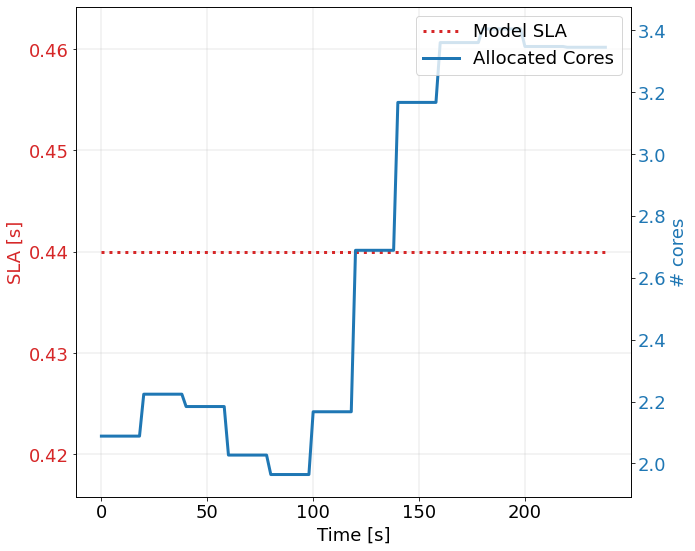

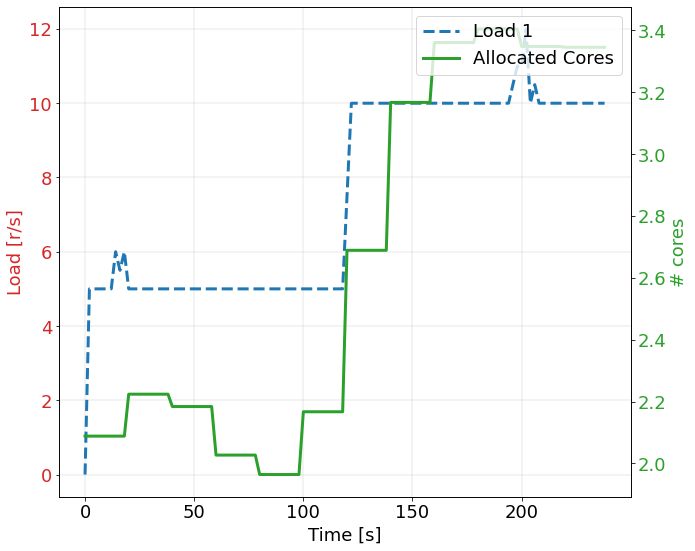

In [101]:
show_values(base_folder + "benchmark_resnet_NHWC_small.out", 2,aggregate=10)

#### vgg16

In [ ]:
show_values(base_folder + "benchmark_vgg16_small.out", 2, aggregate=10)

#### googlenet min c=0.1

In [ ]:
try:
    show_values(base_folder + "benchmark_googlenet_small.out", 2, aggregate=10)
except Exception as e:
    pass

#### skyline_extraction

##### min c=1, sla=0.25

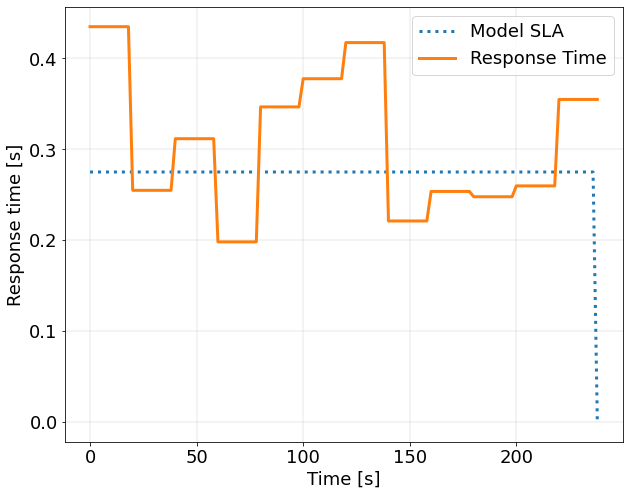

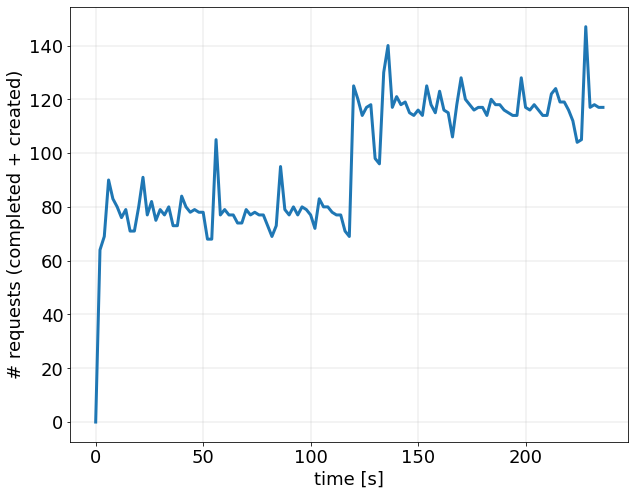

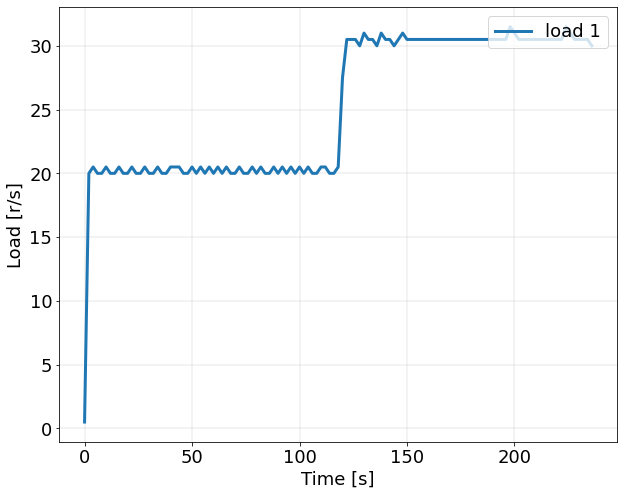

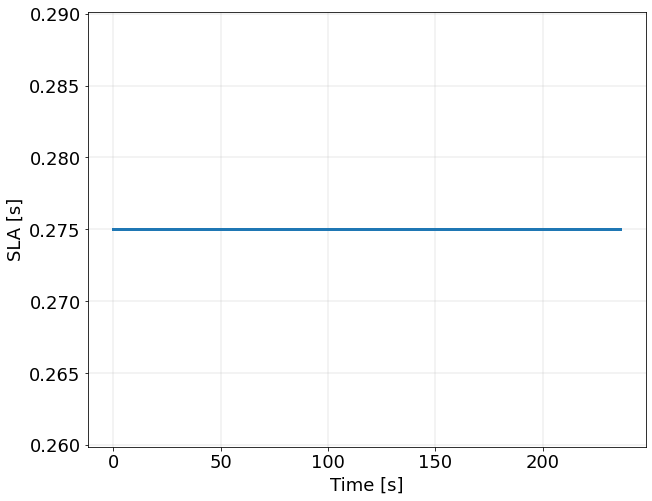

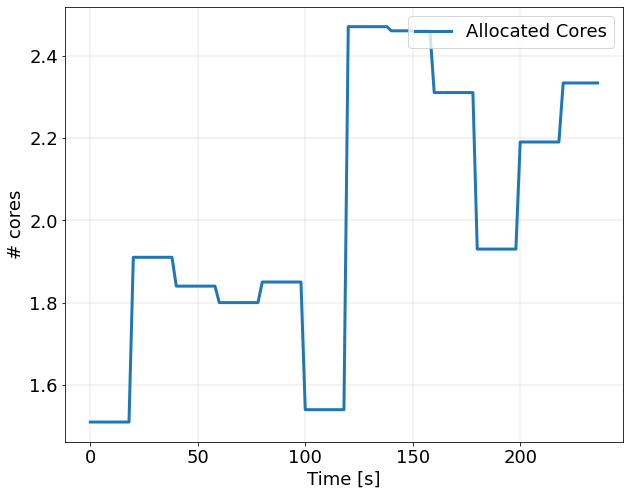

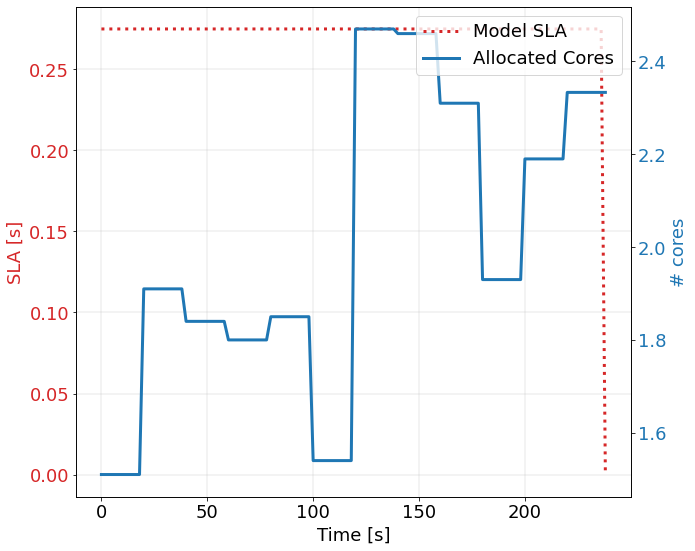

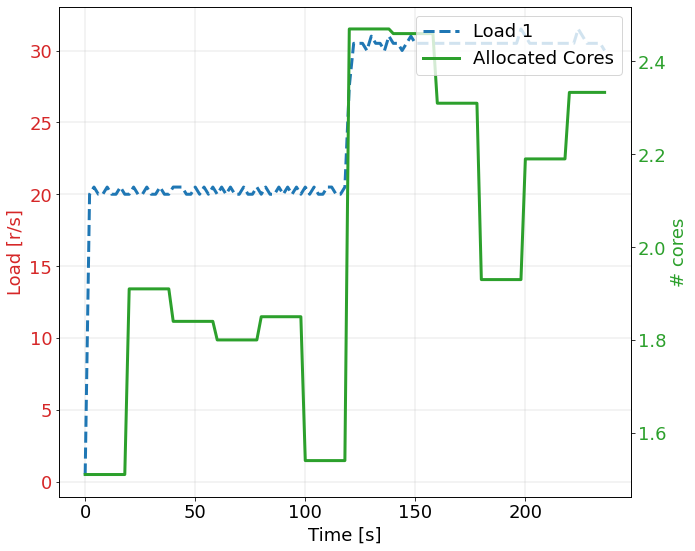

In [93]:
show_values(base_folder + "benchmark_skyline_extraction_small_025.out", 2, aggregate=10)

##### min c=1, sla=0.35

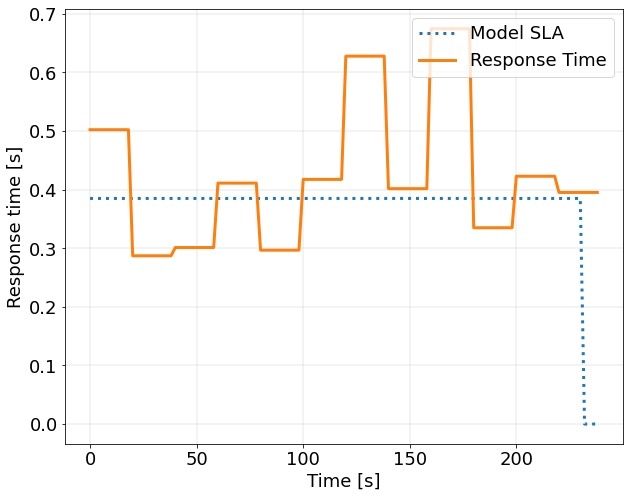

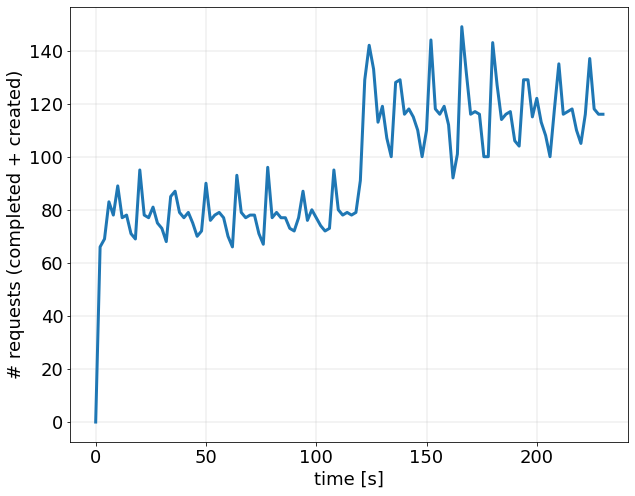

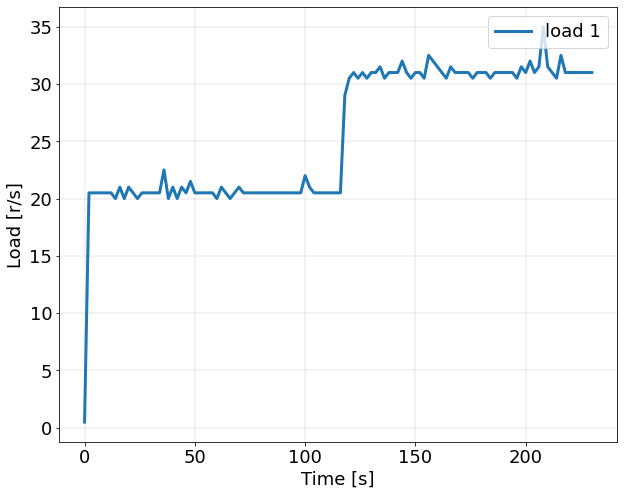

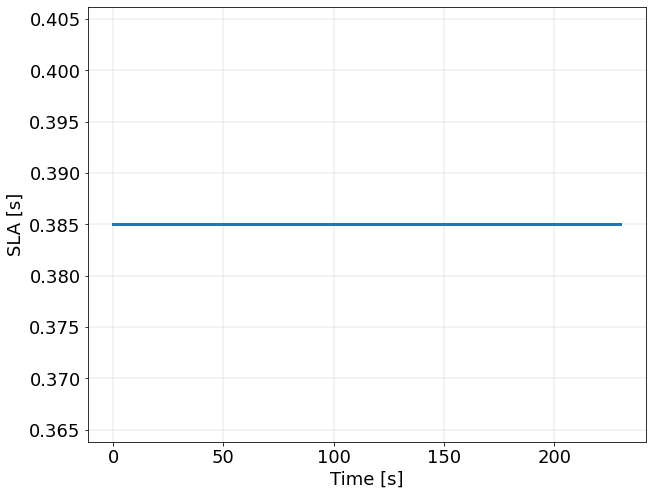

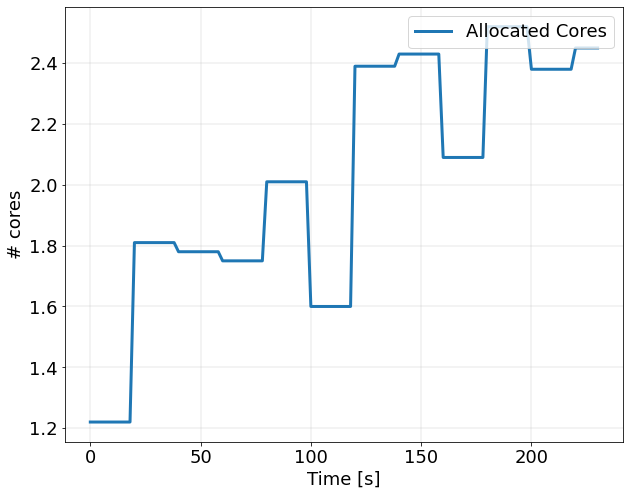

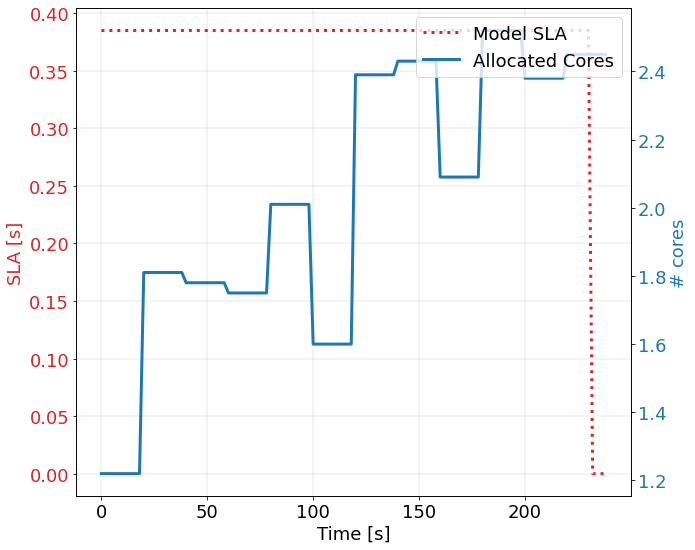

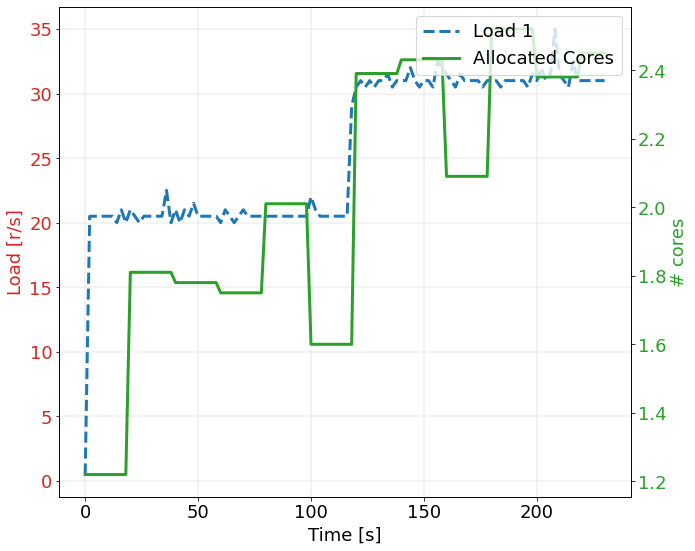

In [92]:
show_values(base_folder + "benchmark_skyline_extraction_small_035.out", 2, aggregate=10)

## System

In [ ]:
def plt_rt(model_id, file, sampling_time, color, verbose=False, aggregate=None):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
    
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    if verbose:
        print("avgs rt: ", benchmark_rt)
        print("model_sla: ", benchmark_model_sla)
    
    # plot
    x_val = np.arange(len(benchmark_rt))
    slas = set(benchmark_model_sla)
    plt.xlabel('Time [s]')
    plt.ylabel('Response time [s]')
    # plt.title('Response Time')
    for i, sla in enumerate(slas):
        plt.plot(x_val*sampling_time, [sla]*len(x_val), ':', c=color, label="SLA " + str(model_id))
    plt.plot(x_val*sampling_time, benchmark_rt, c=color, label="RT " + str(model_id))
    # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(benchmark_rt), '--', c=color, label="Avg RT " + str(model_id))
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_sent(model_id, file, sampling_time, color, verbose=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    for i,_ in enumerate(benchmark_sent):
        for j,_ in enumerate(benchmark_sent[i]):
            benchmark_sent[i][j] = benchmark_sent[i][j] / sampling_time
    
    if verbose:
        print("req sent: ", benchmark_sent)
    
    x_val = np.arange(len(benchmark_sent))
    plt.xlabel('Time [s]')
    plt.ylabel('# requests sent')
    # plt.title('Workload')
    lines = plt.plot(x_val*sampling_time, benchmark_sent, c=color, label="Load " + str(model_id))
    labels = []
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("load " + str(l+1))
    plt.legend(iter(lines), labels)
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_quota(model_id, file, sampling_time, color, max_c=None, show_c=None, verbose=False, aggregate=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
            
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate
            
    if verbose:
        print("ontainers_quota: ", benchmark_container_quota)
    
    for container in benchmark_container_quota:
        x_val = np.arange(len(benchmark_container_quota[container]))
        if show_c is not None:
            if container in show_c:
                plt.plot(x_val*sampling_time, benchmark_container_quota[container], c=color, label="Container " + str(model_id))
        else:
            plt.plot(x_val*sampling_time, benchmark_container_quota[container], c=color, label=container[:12])

    # print max cores
    if max_c:
        plt.plot(x_val*sampling_time, [max_c]*len(x_val), "--", c="m", label="Max")
    plt.legend(loc=1)
    plt.xlabel('Time [s]')
    plt.ylabel('# cores')
    # plt.title('Containers Cores')
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_req(model_id, file, sampling_time, color, verbose=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)

    benchmark_req = benchmark_data[2]
    if verbose:
        print("req: ", benchmark_req)

    x_val = np.arange(len(benchmark_req))
    plt.xlabel('Time [s]')
    plt.ylabel('# requests (completed + created)')
    # plt.title('# requests')
    plt.plot(x_val*sampling_time, benchmark_req, c=color)
    plt.grid(True, linewidth=0.3, linestyle='-')

In [ ]:
def show_stats(file, sampling_time, aggregate=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
        
    
    print("RT: avg: {:.4f}, max: {:.4f}, std: {:.4f}\n".format(stat.mean(benchmark_rt),
                                                              max(benchmark_rt),
                                                              stat.stdev(benchmark_rt)))
    
    sla = benchmark_model_sla[0]
    violations = list(filter(lambda v: v > sla, benchmark_rt))
    
    print("Violations: {} - {:.2f}%\n".format(len(violations), len(violations)/len(benchmark_rt)*100))
    
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
        
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate
    
    for container in benchmark_container_quota:
        quotas = benchmark_container_quota[container]
        active = sum(quotas)
        print("Container {}:\nactive: {:.2f}, total: {:.2f}\n".format(container, active, active*sampling_time))
        

### System Variable reqs/s

In [ ]:
# show_values(base_folder + "benchmark_skyline_extraction.out",2)
# show_values(base_folder + "benchmark_googlenet.out",2)
containers = ["1554becf604613810885d2d62ea664ca886d944905396071887e959ff4713c55", "79b7be123c4911e5a2eace357853bbe8886532e53601c354abccacf8f7d6ebea"]
output_folder = "plot_output/"
for control in ["control/high", "no_control_gpu_only/high"]: #["control/low", "no_control_min_cpu", "no_control_max_cpu", "no_control_cpu_only", "no_control_gpu_only/low", "control/high", "no_control_gpu_only/high"]: # "no_control_min_cpu", "no_control_max_cpu", "no_control_cpu_only",
    for strategy in ["random", "rr", "lq", "h1"]: # ["random", "rr", "lq", "h1"]:
        print(control + " " + strategy)
        base_folder = "complete/" + control + "/" + strategy + "/"

        """
        print("---------------- Skyline")
        show_stats(base_folder + "benchmark_skyline_extraction.out", 2)
        print("---------------- GoogLeNet")
        show_stats(base_folder + "benchmark_googlenet.out", 2)
        """

        print("++++++ AGGREGATED")
        print("---------------- Skyline")
        show_stats(base_folder + "benchmark_skyline_extraction.out", 2, aggregate=10)
        print("---------------- GoogLeNet")
        show_stats(base_folder + "benchmark_googlenet.out", 2, aggregate=10)

        """
        plt_rt(1, base_folder + "benchmark_skyline_extraction.out", 2, 'r')
        plt_rt(2, base_folder + "benchmark_googlenet.out", 2, 'c')
        plt.show()
        """
        
        print("++++++ AGGREGATED")
        plt_rt(1, base_folder + "benchmark_skyline_extraction.out", 2, 'r', aggregate=10)
        plt_rt(2, base_folder + "benchmark_googlenet.out", 2, 'c', aggregate=10)
        plt.savefig(output_folder + "rt_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
        plt.show()

        plt_sent(1, base_folder + "benchmark_skyline_extraction.out", 2, 'r')
        plt_sent(2, base_folder + "benchmark_googlenet.out",2, 'c')
        plt.savefig(output_folder + "sent_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
        plt.show()

        plt_req(1, base_folder + "benchmark_skyline_extraction.out",2, 'r')
        plt_req(2, base_folder + "benchmark_googlenet.out",2, 'c')
        plt.savefig(output_folder + "req_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
        plt.show()

        """
        plt_quota(1, base_folder + "benchmark_skyline_extraction.out",2, 'r', show_c=containers)
        plt_quota(2, base_folder + "benchmark_googlenet.out", 2, 'c', max_c=6, show_c=containers)
        plt.show()
        """

        print("++++++ AGGREGATED")
        plt_quota(1, base_folder + "benchmark_skyline_extraction.out",2, 'r', show_c=containers, aggregate=10)
        plt_quota(2, base_folder + "benchmark_googlenet.out",2, 'c', max_c=6, show_c=containers, aggregate=10)
        plt.savefig(output_folder + "quota_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
        plt.show()